# **Data Description**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
# Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import GridSearchCV,StratifiedKFold,KFold,train_test_split,cross_val_score,cross_val_predict
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier,RandomForestClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,f1_score,precision_score
from sklearn.pipeline import Pipeline
from time import time
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Data Reading
stress_c= pd.read_csv('Stress.csv')
stress=stress_c.copy()
stress.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005


In [4]:
# Info
stress.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subreddit         2838 non-null   object 
 1   post_id           2838 non-null   object 
 2   sentence_range    2838 non-null   object 
 3   text              2838 non-null   object 
 4   label             2838 non-null   int64  
 5   confidence        2838 non-null   float64
 6   social_timestamp  2838 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 155.3+ KB


In [5]:
# Checking null values
stress.isnull().sum()

subreddit           0
post_id             0
sentence_range      0
text                0
label               0
confidence          0
social_timestamp    0
dtype: int64

In [6]:
# Statistical Information
stress.describe()

,label,confidence,social_timestamp
count,2838.000000,2838.000000,2.838000e+03
mean,0.524313,0.808972,1.518107e+09
std,0.499497,0.177038,1.552209e+07
min,0.000000,0.428571,1.483274e+09
25%,0.000000,0.600000,1.509698e+09
50%,1.000000,0.800000,1.517066e+09
75%,1.000000,1.000000,1.530898e+09
max,1.000000,1.000000,1.542592e+09


# **EDA**

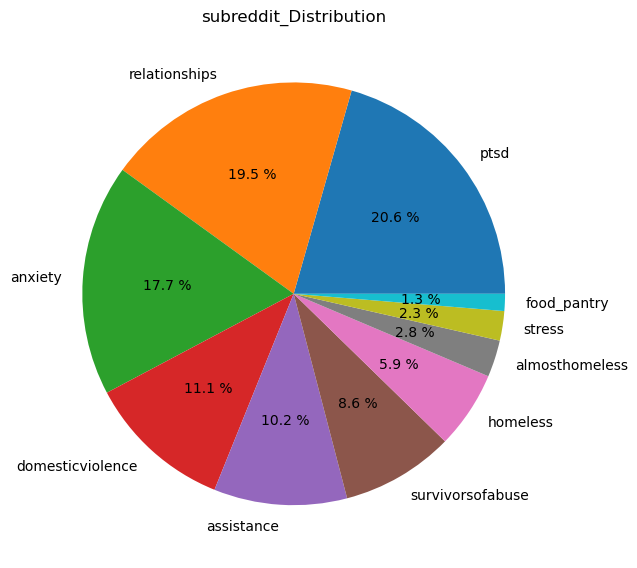

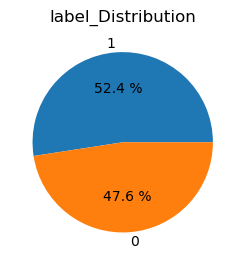

In [7]:
lst=['subreddit','label']
plt.figure(figsize=(15,12))
for i in range(len(lst)):
    plt.subplot(1,2,i+1)
    a=stress[lst[i]].value_counts()
    lbl=a.index
    plt.title(lst[i]+'_Distribution')
    plt.pie(x=a,labels=lbl,autopct="%.1f %%")
    plt.show()

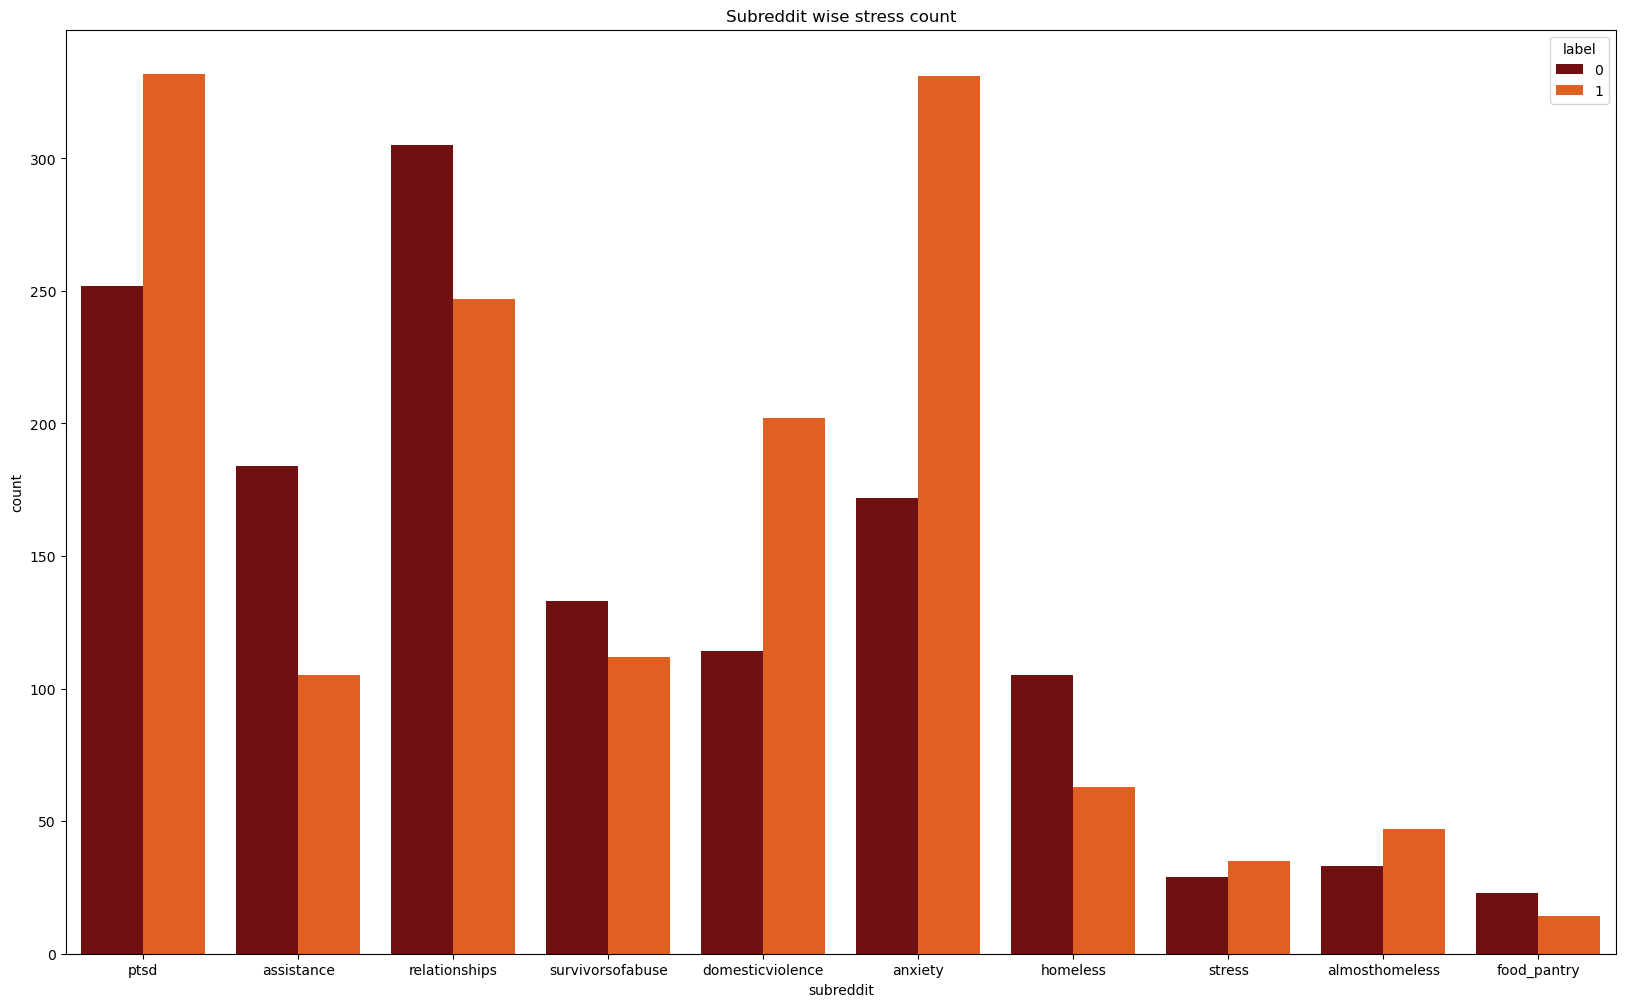

In [8]:
plt.figure(figsize=(20,12))
plt.title('Subreddit wise stress count')
plt.xlabel('Subreddit')
sns.countplot(data=stress,x='subreddit',hue='label',palette='gist_heat')
plt.show()

# **Text Preprocessing**

In [9]:
# Regular Expression
import re 

# Handling string
import string

# NLP tool
import spacy

nlp=spacy.load('en_core_web_sm')
from spacy.lang.en.stop_words import STOP_WORDS

# Importing Natural Language Tool Kit for NLP operations
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')                                #Multilingual Wordnet Data from OMW with newer Wordnet versions


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [10]:
#defining function for preprocessing
def preprocess(text,remove_digits=True):
    text = re.sub('\W+',' ', text)                                        #for replacing non-word characters
    text = re.sub('\s+',' ', text)                                        #for replacng extra spaces
    text = re.sub("(?<!\w)\d+", "", text)                                 # Remove all numbers except those attached to a word
    text = re.sub("-(?!\w)|(?<!\w)-", "", text)                           # Remove all hyphens except between two words
    text=text.lower()
    nopunc=[char for char in text if char not in string.punctuation]      #for removing punctuation in the strings
    nopunc=''.join(nopunc)
    nopunc=' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])   #for removing stop words
    
    
    return nopunc
# Defining a function for lemitization
def lemmatize(words):
   
    words=nlp(words)
    lemmas = []
    for word in words:
        
        lemmas.append(word.lemma_)
    return lemmas



#converting them into string
def listtostring(s):
    str1=' '
    return (str1.join(s))

def clean_text(input):
    word=preprocess(input)
    lemmas=lemmatize(word)
    return listtostring(lemmas)

In [11]:
# Creating a feature to store clean texts
stress['clean_text']=stress['text'].apply(clean_text)
stress.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,clean_text
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353,say feel way suggete go rest trigger ahead you...
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817,hey r assistance sure right place post go curr...
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605,mom hit newspaper shock would know like play h...
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555,meet new boyfriend amazing kind sweet good stu...
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005,october domestic violence awareness month dome...


# **Machine Learning Model Building**

In [13]:
# Defining target & feature for ML model building
x=stress['clean_text']
y=stress['label']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=1)

In [14]:
# Self defining function to convert the data into vector form by tf idf vectorizer and classify and create model by Logistic regression

def model_lr_tf(x_train, x_test, y_train, y_test):
    global acc_lr_tf,f1_lr_tf
    # Text to vector transformation 
    vector = TfidfVectorizer()
    x_train = vector.fit_transform(x_train)
    x_test = vector.transform(x_test)
    

    
 
    ovr = LogisticRegression()
    
    #fitting training data into the model & predicting
    t0 = time()

    ovr.fit(x_train, y_train)
    
    y_pred = ovr.predict(x_test)
    
    # Model Evaluation
    
    conf=confusion_matrix(y_test,y_pred)
    acc_lr_tf=accuracy_score(y_test,y_pred)
    f1_lr_tf=f1_score(y_test,y_pred,average='weighted')
    print('Time :',time()-t0)
    print('Accuracy: ',acc_lr_tf)
    print(10*'===========')
    print('Confusion Matrix: \n',conf)
    print(10*'===========')
    print('Classification Report: \n',classification_report(y_test,y_pred))
    
    
    return y_test,y_pred,acc_lr_tf

# Self defining function to convert the data into vector form by tf idf vectorizer and classify and create model by MultinomialNB

def model_nb_tf(x_train, x_test, y_train, y_test):
    global acc_nb_tf,f1_nb_tf
    # Text to vector transformation 
    vector = TfidfVectorizer()
    x_train = vector.fit_transform(x_train)
    x_test = vector.transform(x_test)
    

    

    ovr = MultinomialNB()
    
    #fitting training data into the model & predicting
    t0 = time()
    
    ovr.fit(x_train, y_train)
    
    y_pred = ovr.predict(x_test)
    
    # Model Evaluation
    
    conf=confusion_matrix(y_test,y_pred)
    acc_nb_tf=accuracy_score(y_test,y_pred)
    f1_nb_tf=f1_score(y_test,y_pred,average='weighted')
    print('Time : ',time()-t0)
    print('Accuracy: ',acc_nb_tf)
    print(10*'===========')
    print('Confusion Matrix: \n',conf)
    print(10*'===========')
    print('Classification Report: \n',classification_report(y_test,y_pred))
    
    
    return y_test,y_pred,acc_nb_tf

# Self defining function to convert the data into vector form by tf idf vectorizer and classify and create model by Decision Tree
def model_dt_tf(x_train, x_test, y_train, y_test):
    global acc_dt_tf,f1_dt_tf
    # Text to vector transformation 
    vector = TfidfVectorizer()
    x_train = vector.fit_transform(x_train)
    x_test = vector.transform(x_test)
    

    

    ovr = DecisionTreeClassifier(random_state=1)
    
    #fitting training data into the model & predicting
    t0 = time()
    
    ovr.fit(x_train, y_train)
    
    y_pred = ovr.predict(x_test)
    
    # Model Evaluation
    
    conf=confusion_matrix(y_test,y_pred)
    acc_dt_tf=accuracy_score(y_test,y_pred)
    f1_dt_tf=f1_score(y_test,y_pred,average='weighted')
    print('Time : ',time()-t0)
    print('Accuracy: ',acc_dt_tf)
    print(10*'===========')
    print('Confusion Matrix: \n',conf)
    print(10*'===========')
    print('Classification Report: \n',classification_report(y_test,y_pred))
    
    
    return y_test,y_pred,acc_dt_tf

# Self defining function to convert the data into vector form by tf idf vectorizer and classify and create model by KNN

def model_knn_tf(x_train, x_test, y_train, y_test):
    global acc_knn_tf,f1_knn_tf
    # Text to vector transformation 
    vector = TfidfVectorizer()
    x_train = vector.fit_transform(x_train)
    x_test = vector.transform(x_test)
    

    

    ovr = KNeighborsClassifier()
    
    #fitting training data into the model & predicting
    t0 = time()
    
    ovr.fit(x_train, y_train)
    
    y_pred = ovr.predict(x_test)
    
    # Model Evaluation
    
    conf=confusion_matrix(y_test,y_pred)
    acc_knn_tf=accuracy_score(y_test,y_pred)
    f1_knn_tf=f1_score(y_test,y_pred,average='weighted')
    print('Time : ',time()-t0)
    print('Accuracy: ',acc_knn_tf)
    print(10*'===========')
    print('Confusion Matrix: \n',conf)
    print(10*'===========')
    print('Classification Report: \n',classification_report(y_test,y_pred))

# Self defining function to convert the data into vector form by tf idf vectorizer and classify and create model by Random Forest

def model_rf_tf(x_train, x_test, y_train, y_test):
    global acc_rf_tf,f1_rf_tf
    # Text to vector transformation 
    vector = TfidfVectorizer()
    x_train = vector.fit_transform(x_train)
    x_test = vector.transform(x_test)
    

    

    ovr = RandomForestClassifier(random_state=1)
    
    #fitting training data into the model & predicting
    t0 = time()
    
    ovr.fit(x_train, y_train)
    
    y_pred = ovr.predict(x_test)
    
    # Model Evaluation
    
    conf=confusion_matrix(y_test,y_pred)
    acc_rf_tf=accuracy_score(y_test,y_pred)
    f1_rf_tf=f1_score(y_test,y_pred,average='weighted')
    print('Time : ',time()-t0)
    print('Accuracy: ',acc_rf_tf)
    print(10*'===========')
    print('Confusion Matrix: \n',conf)
    print(10*'===========')
    print('Classification Report: \n',classification_report(y_test,y_pred))

# Self defining function to convert the data into vector form by tf idf vectorizer and classify and create model by Adaptive Boosting

def model_ab_tf(x_train, x_test, y_train, y_test):
    global acc_ab_tf,f1_ab_tf
    # Text to vector transformation 
    vector = TfidfVectorizer()
    x_train = vector.fit_transform(x_train)
    x_test = vector.transform(x_test)
    

    
    ovr = AdaBoostClassifier(random_state=1)
    
    #fitting training data into the model & predicting
    t0 = time()
    
    ovr.fit(x_train, y_train)
    
    y_pred = ovr.predict(x_test)
    
    # Model Evaluation
    
    conf=confusion_matrix(y_test,y_pred)
    acc_ab_tf=accuracy_score(y_test,y_pred)
    f1_ab_tf=f1_score(y_test,y_pred,average='weighted')
    print('Time : ',time()-t0)
    print('Accuracy: ',acc_ab_tf)
    print(10*'===========')
    print('Confusion Matrix: \n',conf)
    print(10*'===========')
    print('Classification Report: \n',classification_report(y_test,y_pred))
    

# **Model Evaluation**

In [15]:
# Evaluating Models

print('********************Logistic Regression*********************')
print('\n')
model_lr_tf(x_train, x_test, y_train, y_test)
print('\n')
print(30*'==========')
print('\n')
print('********************Multinomial NB*********************')
print('\n')
model_nb_tf(x_train, x_test, y_train, y_test)
print('\n')
print(30*'==========')
print('\n')
print('********************Decision Tree*********************')
print('\n')
model_dt_tf(x_train, x_test, y_train, y_test)
print('\n')
print(30*'==========')
print('\n')
print('********************KNN*********************')
print('\n')
model_knn_tf(x_train, x_test, y_train, y_test)
print('\n')
print(30*'==========')
print('\n')
print('********************Random Forest Bagging*********************')
print('\n')
model_rf_tf(x_train, x_test, y_train, y_test)
print('\n')
print(30*'==========')
print('\n')
print('********************Adaptive Boosting*********************')
print('\n')
model_ab_tf(x_train, x_test, y_train, y_test)
print('\n')
print(30*'==========')
print('\n')

********************Logistic Regression*********************


Time : 0.038251638412475586
Accuracy:  0.7335680751173709
Confusion Matrix: 
 [[279 115]
 [112 346]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.71      0.71      0.71       394
           1       0.75      0.76      0.75       458

    accuracy                           0.73       852
   macro avg       0.73      0.73      0.73       852
weighted avg       0.73      0.73      0.73       852





********************Multinomial NB*********************


Time :  0.004836559295654297
Accuracy:  0.7065727699530516
Confusion Matrix: 
 [[182 212]
 [ 38 420]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.46      0.59       394
           1       0.66      0.92      0.77       458

    accuracy                           0.71       852
   macro avg       0.75      0.69      0.68       852
weighted avg       0.74

# **Model Performance Comparison**

In [16]:
# Creating tabular format for better comparison
tbl=pd.DataFrame()
tbl['Model']=pd.Series(['Logistic Regreesion','Multinomial NB','Decision Tree','KNN','Random Forest','Adaptive Boosting'])
tbl['Accuracy']=pd.Series([acc_lr_tf,acc_nb_tf,acc_dt_tf,acc_knn_tf,acc_rf_tf,acc_ab_tf])
tbl['F1_Score']=pd.Series([f1_lr_tf,f1_nb_tf,f1_dt_tf,f1_knn_tf,f1_rf_tf,f1_ab_tf])
tbl.set_index('Model')

,Accuracy,F1_Score
Model,,
Logistic Regreesion,0.733568,0.733494
Multinomial NB,0.706573,0.688416
Decision Tree,0.607981,0.608361
KNN,0.683099,0.680416
Random Forest,0.714789,0.712023
Adaptive Boosting,0.637324,0.637836


In [17]:
# Best model on the basis of F1 Score
tbl.sort_values('F1_Score',ascending=False)

,Model,Accuracy,F1_Score
0,Logistic Regreesion,0.733568,0.733494
4,Random Forest,0.714789,0.712023
1,Multinomial NB,0.706573,0.688416
3,KNN,0.683099,0.680416
5,Adaptive Boosting,0.637324,0.637836
2,Decision Tree,0.607981,0.608361


# **Cross Validation To Avoid Overfitting**


 LogisticRegression()
f1-Score(train): mean= (0.739), min=(0.709)) ,max= (0.786), stdev= (0.026)
f1-Score(test): 0.7388

 MultinomialNB()
f1-Score(train): mean= (0.671), min=(0.613)) ,max= (0.718), stdev= (0.035)
f1-Score(test): 0.6721

 DecisionTreeClassifier(random_state=1)
f1-Score(train): mean= (0.603), min=(0.575)) ,max= (0.617), stdev= (0.015)
f1-Score(test): 0.6036

 KNeighborsClassifier()
f1-Score(train): mean= (0.648), min=(0.599)) ,max= (0.678), stdev= (0.026)
f1-Score(test): 0.6480

 RandomForestClassifier(random_state=1)
f1-Score(train): mean= (0.715), min=(0.685)) ,max= (0.760), stdev= (0.028)
f1-Score(test): 0.7152

 AdaBoostClassifier(random_state=1)
f1-Score(train): mean= (0.672), min=(0.640)) ,max= (0.695), stdev= (0.022)
f1-Score(test): 0.6718


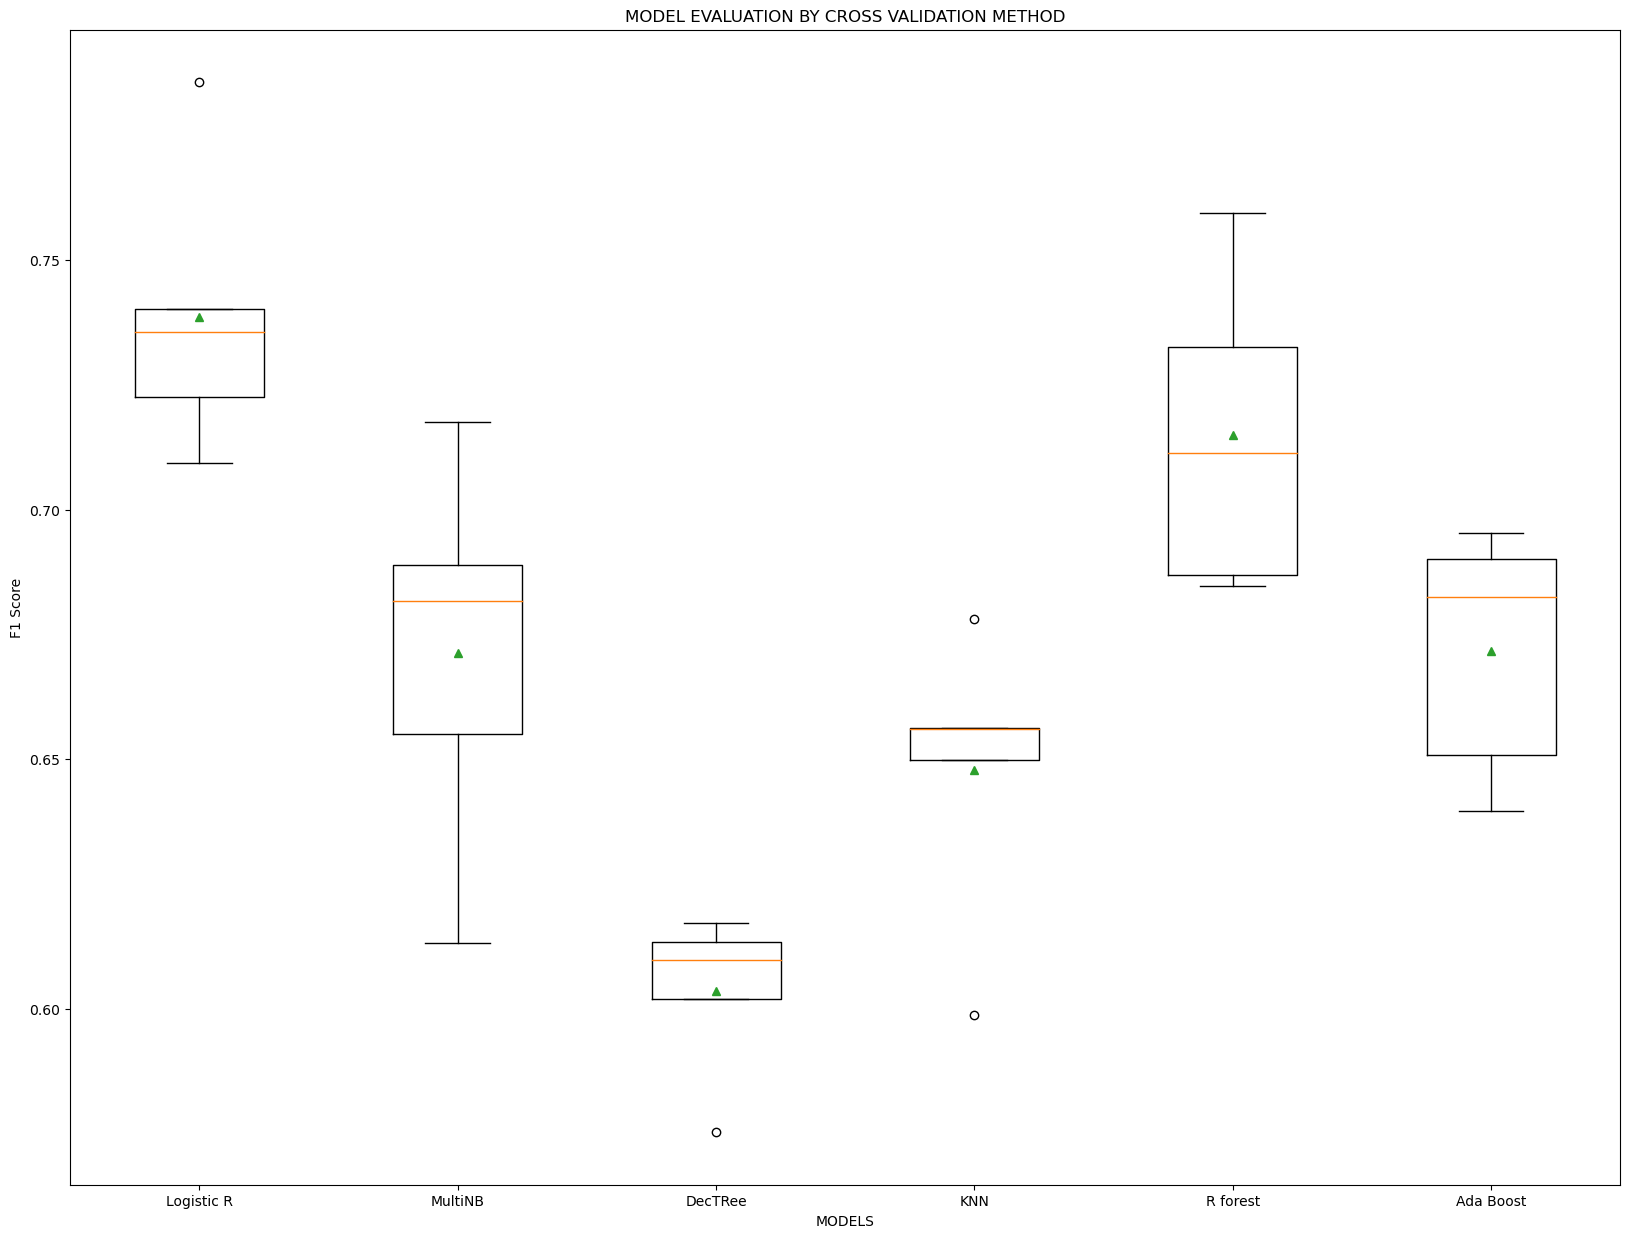

In [18]:
# Using cross validation method to avoid overfitting
import statistics as st
vector = TfidfVectorizer()

x_train_v = vector.fit_transform(x_train)
x_test_v  = vector.transform(x_test)
###############################################################################
# Model building
lr =LogisticRegression()
mnb=MultinomialNB()
dct=DecisionTreeClassifier(random_state=1)
knn=KNeighborsClassifier()
rf=RandomForestClassifier(random_state=1)
ab=AdaBoostClassifier(random_state=1)
m  =[lr,mnb,dct,knn,rf,ab]
model_name=['Logistic R','MultiNB','DecTRee','KNN','R forest','Ada Boost']

results, mean_results, p, f1_test=list(),list(),list(),list()

################################################################################
#Model fitting,cross-validating and evaluating performance

def algor(model):
    print('\n',i)
    pipe=Pipeline([('model',model)])
    pipe.fit(x_train_v,y_train)
    cv=StratifiedKFold(n_splits=5)
    n_scores=cross_val_score(pipe,x_train_v,y_train,scoring='f1_weighted',cv=cv,n_jobs=-1,error_score='raise') # As it is an Imbalance data so f1 score will give a better accuracy than normal accuracy.
    results.append(n_scores)
    mean_results.append(st.mean(n_scores))
    print('f1-Score(train): mean= (%.3f), min=(%.3f)) ,max= (%.3f), stdev= (%.3f)'%(st.mean(n_scores), min(n_scores), max(n_scores),np.std(n_scores)))
    y_pred=cross_val_predict(model,x_train_v,y_train,cv=cv)
    p.append(y_pred)
    f1=f1_score(y_train,y_pred, average = 'weighted')
    f1_test.append(f1)
    print('f1-Score(test): %.4f'%(f1))

for i in m:
    algor(i)

###############################################################################
# Model comparison By Visualizing 

fig=plt.subplots(figsize=(20,15))
plt.title('MODEL EVALUATION BY CROSS VALIDATION METHOD')
plt.xlabel('MODELS')
plt.ylabel('F1 Score')
plt.boxplot(results,labels=model_name,showmeans=True)
plt.show()
     

* As F1 score of the models are coming quite simmmilar by both methods. So now we are applying Leave One Out method to build the best performed model.

In [19]:
x=stress['clean_text']
y=stress['label']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=1)

vector = TfidfVectorizer()
x_train = vector.fit_transform(x_train)
x_test = vector.transform(x_test)
model_lr_tf=LogisticRegression()

model_lr_tf.fit(x_train,y_train)
y_pred=model_lr_tf.predict(x_test)
# Model Evaluation
    
conf=confusion_matrix(y_test,y_pred)
acc_lr=accuracy_score(y_test,y_pred)
f1_lr=f1_score(y_test,y_pred,average='weighted')

print('Accuracy: ',acc_lr)
print('F1 Score: ',f1_lr)
print(10*'===========')
print('Confusion Matrix: \n',conf)
print(10*'===========')
print('Classification Report: \n',classification_report(y_test,y_pred))

Accuracy:  0.7335680751173709
F1 Score:  0.73349384209352
Confusion Matrix: 
 [[279 115]
 [112 346]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.71      0.71      0.71       394
           1       0.75      0.76      0.75       458

    accuracy                           0.73       852
   macro avg       0.73      0.73      0.73       852
weighted avg       0.73      0.73      0.73       852



# **Word Clouds of Stressed & Non-stressed words**

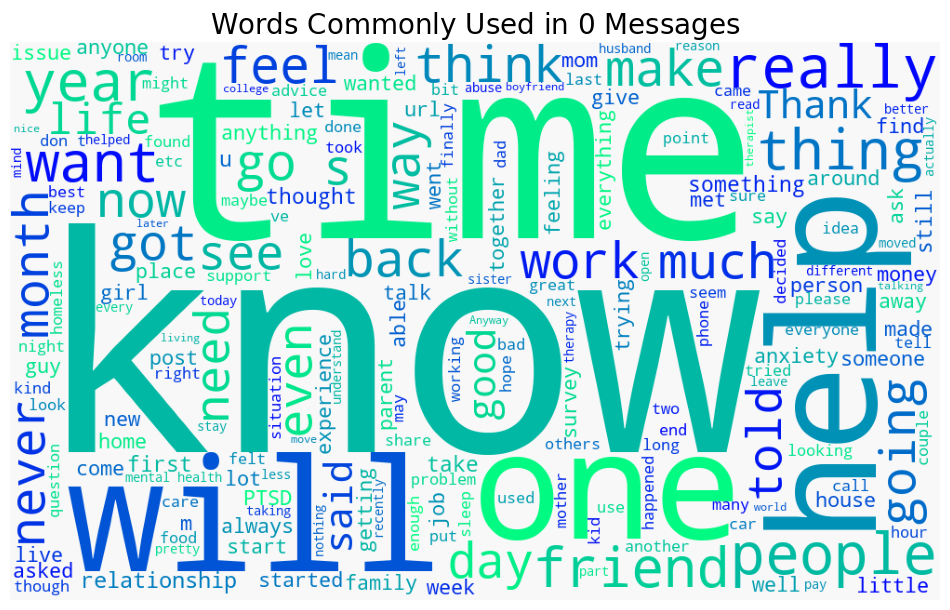

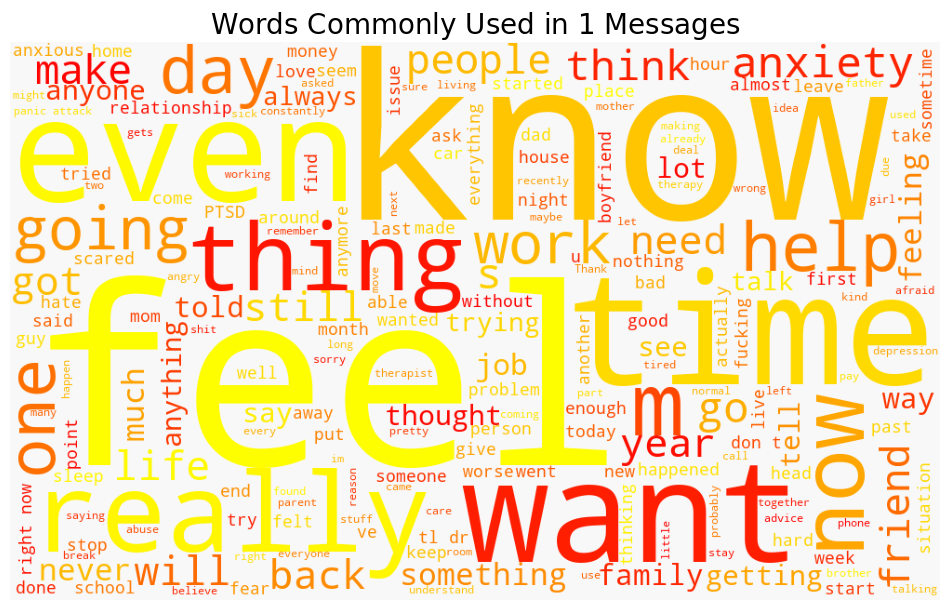

In [20]:
for label, cmap in zip([0,1],
                       ['winter', 'autumn', 'magma', 'viridis', 'plasma']):
    text = stress.query('label == @label')['text'].str.cat(sep=' ')
    plt.figure(figsize=(12, 9))
    wc = WordCloud(width=1000, height=600, background_color="#f8f8f8", colormap=cmap)
    wc.generate_from_text(text)
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Words Commonly Used in ${label}$ Messages", size=20)
    plt.show()

# **Prediction**

In [21]:
data=["""I don't have the ability to cope with it anymore. I'm trying, but a lot of things are triggering me, 
and I'm shutting down at work, just finding the place I feel safest, and staying there for an hour or two until 
I feel like I can do something again. I'm tired of watching my back, tired of traveling to places I don't feel safe, 
tired of reliving that moment, tired of being triggered, tired of the stress, tired of anxiety and knots in my stomach, 
tired of irrational thought when triggered, tired of irrational paranoia. I'm exhausted and need a break, but know it won't be 
enough until I journey the long road through therapy. I'm not suicidal at all, just wishing this pain and misery would end, to have my life back again."""]
data=vector.transform(data)
model_lr_tf.predict(data)

array([1])

In [22]:
data=["""In case this is the first time you're reading this post... We are looking for people who are willing 
to complete some online questionnaires about employment and well-being which we hope will help us to improve services 
for assisting people with mental health difficulties to obtain and retain employment. We are developing an employment 
questionnaire for people with personality disorders; however we are looking for people from all backgrounds to complete it. 
That means you do not need to have a diagnosis of personality disorder – you just need to have an interest in completing the 
online questionnaires. The questionnaires will only take about 10 minutes to complete online. For your participation, we’ll 
donate £1 on your behalf to a mental health charity (Young Minds: Child & Adolescent Mental Health, Mental Health Foundation, or Rethink)"""]
data=vector.transform(data)
model_lr_tf.predict(data)

array([0])